# Object Detection
* 2 people in a group
* Deadline: 10/13

## Dataset

- PASCAL VOC 2007
  - Number of class: 20
  - The data list is provided in the google drive. However, you have to download the training/testing data from http://host.robots.ox.ac.uk/pascal/VOC/voc2007/. 
    - Train/Val data: 5011
        - Each row contains one image and its bounding boxes.
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 1
    - Test data: 4951
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0
    


### Loading your data into Google Colab with Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
GRID_NUM = 7

## Resnet50 backbone

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls
from torchsummary import summary

class classify_bottleneck(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, block_type='A'):
    super(classify_bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=2, bias=False,dilation=2)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(planes)

    self.downsample = nn.Sequential()
    if stride != 1 or block_type=='B':
        self.downsample = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.downsample(x)
    out = F.relu(out)
    return out

class ResNetYoloV1(nn.Module):

    def __init__(self, resnet_type):
	
        resnet_spec = {18: (BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256, 512], 'resnet18'),
		       34: (BasicBlock, [3, 4, 6, 3], [64, 64, 128, 256, 512], 'resnet34'),
		       50: (Bottleneck, [3, 4, 6, 3], [64, 256, 512, 1024, 2048], 'resnet50'),
		       101: (Bottleneck, [3, 4, 23, 3], [64, 256, 512, 1024, 2048], 'resnet101'),
		       152: (Bottleneck, [3, 8, 36, 3], [64, 256, 512, 1024, 2048], 'resnet152')}
        block, layers, channels, name = resnet_spec[resnet_type]
        
        self.name = name
        self.inplanes = 64
        super(ResNetYoloV1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.layer5 = self._make_classify_layer(in_channels=2048) #2048*14*14

        self.conv_end = nn.Conv2d(256, 30, kernel_size=3, stride=2, padding=1, bias=False)#30*7*7
        self.bn_end = nn.BatchNorm2d(30)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, mean=0, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def _make_classify_layer(self,in_channels):
        layers = []
        layers.append(classify_bottleneck(inplanes=in_channels, planes=256, block_type='B'))
        layers.append(classify_bottleneck(inplanes=256, planes=256))
        layers.append(classify_bottleneck(inplanes=256, planes=256))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # x4 layer output size: (B, 2048, 7, 7)
        x5 = self.layer5(x4)
        x = self.conv_end(x5)
        x = self.bn_end(x)
        x = torch.sigmoid(x) #归一化到0-1
        # x = x.view(-1,7,7,30)
        x = x.permute(0,2,3,1) #(-1,7,7,30)
        return x

    def init_weights(self):
        org_resnet = torch.utils.model_zoo.load_url(model_urls[self.name])
        # drop orginal resnet fc layer, add 'None' in case of no fc layer, that will raise error
        org_resnet.pop('fc.weight', None)
        org_resnet.pop('fc.bias', None)

        self.load_state_dict(org_resnet)
        print("Initialize resnet from model zoo")

def load_change_weights(model, model_name):
  
  org_resnet = torch.utils.model_zoo.load_url(model_urls[model_name])
  org_resnet.pop('fc.weight', None)
  org_resnet.pop('fc.bias', None)

  dd = model.state_dict()
  for k in org_resnet.keys():
      # print(k)
      if k in dd.keys() and not k.startswith('fc'):
          # print('yes')
          dd[k] = org_resnet[k]
  model.load_state_dict(dd)
  return model

### Assignment
You are required to build a model to perform object detection on the provided Pascal VOC dataset in this project.
Here are some hints that help you to accomplish the project successfully.

### Hints
- YOLOv1 is the simplest and suggested model to be implemented.
- Be careful of the normalization techniques on bounding boxes.
    1. normalize the height and width with image size to fall into 0 and 1
    2. x and y coordinates are parameterized to be the offsets of a particular grid cell and also bounded by 0 and 1
- Loss function has a great impact on training stability.
    1. loss function is the most important in this project, especially in calculating IOU
    2. only one bounding box predictor is responsible for each object
    3. weights for different types of losses
    4. predict the square root of height and width instead of predicting them directly
- Data augmentation.
    1. It contains only 5011 images in total. Furthermore, the labels are highly imbalanced.
    2. Random scaling and translations are applied when training YOLO.
    3. Note that the bounding box coordinates have to be changed accordingly if the image was transformed.

### Evaluation Metric
- Please evaluate your model on Pascal VOC testing set using Mean Average Precision (mAP).
- Write a brief report including your implementation, performance and  qualitative results(visualize bounding box on some images). 
- For more detailed explanation of mAP, please follow https://github.com/rafaelpadilla/Object-Detection-Metrics

In [3]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms


## Dataset & data augmentation

In [4]:
import os.path
import random
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

class yoloDataset(data.Dataset):
    image_size = 448 # Size to be aligned

    # Parsing data list
    def __init__(self,root,list_file,train,transform):
        self.root = root
        self.train = train
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.mean = (123,117,104) # RGB

        # Cat multiple list files together.
        '''if isinstance(list_file, list):
            # This is especially useful for voc07/voc12 combination.
            tmp_file = '/tmp/listfile.txt'
            os.system('cat %s > %s' % (' '.join(list_file), tmp_file))
            list_file = tmp_file'''

        with open(list_file) as f:
            lines  = f.readlines()

        # format of each line: filename (x_min, y_min, x_max, y_max, label) * object_num
        for line in lines:
            splited = line.strip().split() # .strip(): reomove space, tab from the end of each line
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box=[]
            label=[]
            for i in range(num_boxes):
                x = float(splited[1+5*i])
                y = float(splited[2+5*i])
                x2 = float(splited[3+5*i])
                y2 = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x,y,x2,y2])
                label.append(int(c)+1) # +1: since the idx start from 0
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)

    # Getting single transformed, preprocessed image and its target
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        # Randomly transforming image
        if self.train:
            #img = self.random_bright(img)
            img, boxes = self.random_flip(img, boxes)
            img,boxes = self.randomScale(img,boxes)
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img,boxes,labels = self.randomShift(img,boxes,labels)
            img,boxes,labels = self.randomCrop(img,boxes,labels)

        # #debug: showing the transformed image
        # box_show = boxes.numpy().reshape(-1)
        # # print(box_show)
        # img_show = self.BGR2RGB(img)
        # pt1=(int(box_show[0]),int(box_show[1])); pt2=(int(box_show[2]),int(box_show[3]))
        # cv2.rectangle(img_show,pt1=pt1,pt2=pt2,color=(0,255,0),thickness=1)
        # plt.figure()
        
        # plt.imshow(img_show)
        # plt.show()
        # #debug

        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) 
        # .expand_as(other): expand this tensor as other
        # [w, h, w, h] (1, 4) will be expanded to (#box, 4)

        img = self.BGR2RGB(img) # because pytorch pretrained model use RGB
        img = self.subMean(img,self.mean)
        img = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels) # 7x7x30, where 30 = 5*2(xywh+confidence for 2 boxes) + 20(classes)
        for t in self.transform:
            img = t(img)

        return img,target

    def __len__(self):
        return self.num_samples

    # Utils
    # Encoding the boxes, labels for single image
    def encoder(self,boxes,labels):
        grid_num = GRID_NUM
        target = torch.zeros((grid_num,grid_num,30))
        cell_size = 1./grid_num
        wh = boxes[:,2:]-boxes[:,:2]
        cxcy = (boxes[:,2:]+boxes[:,:2])/2
        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i]
            ij = (cxcy_sample/cell_size).ceil()-1 #
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy = ij*cell_size # upper left coordinates of corresponding grid
            delta_xy = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
        return target

    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    
    def subMean(self,bgr,mean):
        mean = np.array(mean, dtype=np.float32)
        bgr = bgr - mean
        return bgr
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5))
        return bgr

    def randomShift(self,bgr,boxes,labels):
        center = (boxes[:,2:]+boxes[:,:2])/2
        if random.random() <0.5:
            height,width,c = bgr.shape
            after_shfit_image = np.zeros((height,width,c),dtype=bgr.dtype)
            after_shfit_image[:,:,:] = (104,117,123) #bgr
            shift_x = random.uniform(-width*0.2,width*0.2)
            shift_y = random.uniform(-height*0.2,height*0.2)
            #print(bgr.shape,shift_x,shift_y)
            #原图像的平移
            if shift_x>=0 and shift_y>=0:
                after_shfit_image[int(shift_y):,int(shift_x):,:] = bgr[:height-int(shift_y),:width-int(shift_x),:]
            elif shift_x>=0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),int(shift_x):,:] = bgr[-int(shift_y):,:width-int(shift_x),:]
            elif shift_x <0 and shift_y >=0:
                after_shfit_image[int(shift_y):,:width+int(shift_x),:] = bgr[:height-int(shift_y),-int(shift_x):,:]
            elif shift_x<0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),:width+int(shift_x),:] = bgr[-int(shift_y):,-int(shift_x):,:]

            shift_xy = torch.FloatTensor([[int(shift_x),int(shift_y)]]).expand_as(center)
            center = center + shift_xy
            mask1 = (center[:,0] >0) & (center[:,0] < width)
            mask2 = (center[:,1] >0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1)
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if len(boxes_in) == 0:
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[int(shift_x),int(shift_y),int(shift_x),int(shift_y)]]).expand_as(boxes_in)
            boxes_in = boxes_in+box_shift
            labels_in = labels[mask.view(-1)]
            return after_shfit_image,boxes_in,labels_in
        return bgr,boxes,labels

    def randomScale(self,bgr,boxes):
        #固定住高度，以0.8-1.2伸缩宽度，做图像形变
        if random.random() < 0.5:
            scale = random.uniform(0.8,1.2)
            height,width,c = bgr.shape
            bgr = cv2.resize(bgr,(int(width*scale),height))
            scale_tensor = torch.FloatTensor([[scale,1,scale,1]]).expand_as(boxes)
            boxes = boxes * scale_tensor
            return bgr,boxes
        return bgr,boxes

    def randomCrop(self,bgr,boxes,labels):
        if random.random() < 0.5:
            center = (boxes[:,2:]+boxes[:,:2])/2
            height,width,c = bgr.shape
            h = random.uniform(0.6*height,height)
            w = random.uniform(0.6*width,width)
            x = random.uniform(0,width-w)
            y = random.uniform(0,height-h)
            x,y,h,w = int(x),int(y),int(h),int(w)

            center = center - torch.FloatTensor([[x,y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1,1)

            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if(len(boxes_in)==0):
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[x,y,x,y]]).expand_as(boxes_in)

            boxes_in = boxes_in - box_shift
            boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
            boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
            boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
            boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

            labels_in = labels[mask.view(-1)]
            img_croped = bgr[y:y+h,x:x+w,:]
            return img_croped,boxes_in,labels_in
        return bgr,boxes,labels

    def random_flip(self, im, boxes):
        if random.random() < 0.5:
            im_lr = np.fliplr(im).copy()
            h,w,_ = im.shape
            xmin = w - boxes[:,2]
            xmax = w - boxes[:,0]
            boxes[:,0] = xmin
            boxes[:,2] = xmax
            return im_lr, boxes
        return im, boxes

    def random_bright(self, im, delta=16): # unused
        alpha = random.random()
        if alpha > 0.3:
            im = im * alpha + random.randrange(-delta,delta)
            im = im.clip(min=0,max=255).astype(np.uint8)
        return im

## Yolov1 Loss


In [5]:
# Loss function
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class yolov1Loss(nn.Module):
    def __init__(self, S, B, C, lambda_coord, lambda_noobj):
        # Args:
        #    S: size of grid
        #    B: number of box
        #    C: number of class
        super(yolov1Loss, self).__init__()
        self.S = S 
        self.B = B 
        self.C = C 
        self.l_coord = lambda_coord
        self.l_noobj = lambda_noobj
    
    def calculateIoU(self, box1, box2):
        # calculate the intersection over the union of two sets of boxes, each box contains [xmin,ymin,xmax,ymax]
        # Args:
        #    size of box1 = [n,4]
        #    size of box2 = [m,4]
        # Return:
        #    size of Iou of two sets of boxes = [n,m]
        n = box1.size(0)
        m = box2.size(0)
        
        # take the max of left-bottom point and the min of right-top point 
        # to calculate the left-top point and the right-bottom point of the intersection
        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(n,m,2), # take [xmin,ymin]: [n,2] -> [n,1,2] -> [n,m,2]
            box2[:,:2].unsqueeze(0).expand(n,m,2)  # take [xmin,ymin]: [m,2] -> [1,m,2] -> [n,m,2]
        )
        
        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(n,m,2), # take [xmax,ymax]: [n,2] -> [n,1,2] -> [n,m,2]
            box2[:,2:].unsqueeze(0).expand(n,m,2)  # take [xmax,ymax]: [m,2] -> [1,m,2] -> [n,m,2]
        )
        
        # calculate weight and height of intersection areas and check if intersection area is 0
        wh = rb - lt # [n,m,2]
        wh[wh<0] = 0 # if max_left >= min_right or max_bottom >= min_top, then there is no intersection
        intersection = wh[:,:,0] * wh[:,:,1] # [n,m]
        
        area1 = (box1[:,2]-box1[:,0])*(box1[:,3]-box1[:,1])  #[n,]     
        area2 = (box2[:,2]-box2[:,0])*(box2[:,3]-box2[:,1])  #[m,]
        area1 = area1.unsqueeze(1).expand(n,m) # [n,] -> [n,1] -> [n,m]
        area2 = area2.unsqueeze(0).expand(n,m) # [m,] -> [1,m] -> [n,m]
        
        iou = intersection / (area1 + area2 - intersection)
        return iou
    def forward(self, preds, targets):
        # Args:
        #    size of preds = [batchsize, S, S, Bx5+20]: Bx5 means each box has [x,y,w,h,c] 5 values
        #    size of targets = [batchsize, S, S, Bx5+20]
        S, B, C = self.S, self.B, self.C
        N = B * 5 + C 
        batchsize = preds.size(0)
        coord_mask = targets[:,:,:,4] > 0        
        noobj_mask = targets[:,:,:,4] == 0
        coord_mask = coord_mask.unsqueeze(-1).expand(batchsize, S, S, N)        
        noobj_mask = noobj_mask.unsqueeze(-1).expand(batchsize, S, S, N)
        
        coord_pred = preds[coord_mask].view(-1, N)
        box_pred = coord_pred[:,:5*B].contiguous().view(-1, 5)
        class_pred = coord_pred[:,5*B:]
        
        coord_target = targets[coord_mask].view(-1, N)
        box_target = coord_target[:,:5*B].contiguous().view(-1, 5)
        class_target = coord_target[:,5*B:]
        
        # compute noobj_loss: only calculate confidence loss
        noobj_pred = preds[noobj_mask].view(-1, N)
        noobj_target = targets[noobj_mask].view(-1, N)
        noobj_pred_mask = torch.cuda.BoolTensor(noobj_pred.size())
        noobj_pred_mask.zero_()
        for b in range(B):
            noobj_pred_mask[:, 4+b*5] = 1
        noobj_pred_conf = noobj_pred[noobj_pred_mask]
        noobj_target_conf = noobj_target[noobj_pred_mask]  
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction = 'sum')
        
        # compute coord_loss
        coord_response_mask = torch.cuda.BoolTensor(box_target.size()).fill_(0) # only compute the loss of the box containing the center of object
        box_target_iou = torch.zeros(box_target.size()).cuda()
        
        # Choose the pred box having the highest IoU for each target boxes
        for i in range(0, box_target.size(0), B):
            # take all predict boxes at i-th cell
            pred_boxes = box_pred[i:i+B]
            pred_xyxy = Variable(torch.FloatTensor(pred_boxes.size()))
            pred_xyxy[:, :2] = pred_boxes[:, :2]/float(S) - 0.5*pred_boxes[:,2:4]
            pred_xyxy[:, 2:4] = pred_boxes[:, :2]/float(S) + 0.5*pred_boxes[:,2:4]   
            
            # take all target boxes at i-th cell
            # Since target boxes contained by each cell are identical in current implement,thus just take the first one
            target_boxes = box_target[i].view(-1, 5)
            target_xyxy = Variable(torch.FloatTensor(target_boxes.size()))
            target_xyxy[:, :2] = target_boxes[:, :2]/float(S) - 0.5*target_boxes[:,2:4]
            target_xyxy[:, 2:4] = target_boxes[:, :2]/float(S) + 0.5*target_boxes[:,2:4]
                                   
            iou = self.calculateIoU(pred_xyxy[:,:4], target_xyxy[:,:4]) # [B,1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()
            
            coord_response_mask[i+max_index] = 1
            box_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        
        # calculate the loss of the response boxes
        box_target_iou = Variable(box_target_iou).cuda()
        box_pred_response = box_pred[coord_response_mask].view(-1, 5)
        box_target_response = box_target[coord_response_mask].view(-1, 5)
        target_iou = box_target_iou[coord_response_mask].view(-1, 5)
        loss_xy = F.mse_loss(box_pred_response[:,:2], box_target_response[:,:2], reduction = 'sum')
        loss_wh = F.mse_loss(torch.sqrt(box_pred_response[:,2:4]), torch.sqrt(box_target_response[:,2:4]), reduction = 'sum')                
        loss_obj = F. mse_loss(box_pred_response[:,4], target_iou[:,4], reduction = 'sum')
        
        # calculate the class probability loss of cells containing objects
        loss_class = F.mse_loss(class_pred, class_target, reduction = 'sum')
        
        # total loss
        loss = self.l_coord * (loss_xy + loss_wh) + loss_obj + self.l_noobj*loss_noobj + loss_class
        loss = loss/float(batchsize)
                                   
        return loss

## Training Process


In [8]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [7]:
batch_size = 8 #64
momentum = 0.9
decay = 0.0005
epochs = 50

file_root = 'VOCdevkit/VOC2007/JPEGImages/'
train_loss = []
valid_loss = []

def train():
  ## model initiate
  learning_rate = 0.001
  yolov1 = ResNetYoloV1(50)
  yolov1 = load_change_weights(yolov1, 'resnet50')

  net = yolov1
  net.cuda()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = momentum, weight_decay=decay)
  # load data
  train_dataset = yoloDataset(root=file_root,list_file=file_root+'voc2007train.txt', train=True,transform = [transforms.ToTensor()] )
  train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
  test_dataset = yoloDataset(root=file_root,list_file=file_root+'voc2007valid.txt',train=False,transform = [transforms.ToTensor()] )
  test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
  print('the dataset has %d images' % (len(train_dataset)))
  print('the batch_size is %d' % (batch_size))
  # training process
  criterion = yolov1Loss(GRID_NUM,2,20,5,0.5)
  best_val_loss = np.inf
  for ep in range(epochs):
    net.train()
    if ep >= 2:
      learning_rate = 0.01
    if ep >= 30:
      learning_rate = 0.001
    if ep >= 45:
      learning_rate = 0.0001
    for param_group in optimizer.param_groups:
      param_group['lr'] = learning_rate
    total_loss = 0.
    total_data = 0.
    for i, (images, target) in enumerate(train_loader):
        images = Variable(images)
        target = Variable(target)
        images,target = images.cuda(),target.cuda()
        batch_size_this_iter = images.size(0)

        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()*batch_size_this_iter
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_data += batch_size_this_iter

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f' 
            %(ep+1, epochs, i+1, len(train_loader), loss.item(), total_loss / total_data))
            train_loss.append(total_loss / total_data)
    #validation process
    validation_loss = 0.0
    net.eval()
    for i, (images, target) in enumerate(test_loader):
      images = Variable(images)
      target = Variable(target)
      images, target = images.cuda(), target.cuda()

      pred = net(images)
      loss = criterion(pred, target)
      validation_loss += loss.item()
    validation_loss/=len(test_loader)
    print('Test epoch [%d/%d], average_loss: %.4f'%(ep+1, epochs, validation_loss))
    valid_loss.append(validation_loss)
    torch.save(net.state_dict(), os.path.join('model_latest.pth'))
    if best_val_loss > validation_loss:
        best_val_loss = validation_loss
        torch.save(net.state_dict(), os.path.join('model_best.pth'))

train()

the dataset has 3508 images
the batch_size is 8
Epoch [1/50], Iter [5/439] Loss: 21.6132, average_loss: 26.0365
Epoch [1/50], Iter [10/439] Loss: 25.4903, average_loss: 23.7071
Epoch [1/50], Iter [15/439] Loss: 17.3300, average_loss: 22.4634
Epoch [1/50], Iter [20/439] Loss: 19.8315, average_loss: 21.8494
Epoch [1/50], Iter [25/439] Loss: 11.3041, average_loss: 20.5039
Epoch [1/50], Iter [30/439] Loss: 13.0496, average_loss: 19.2587
Epoch [1/50], Iter [35/439] Loss: 11.6138, average_loss: 18.3846
Epoch [1/50], Iter [40/439] Loss: 11.8761, average_loss: 17.5948
Epoch [1/50], Iter [45/439] Loss: 12.5501, average_loss: 17.0116
Epoch [1/50], Iter [50/439] Loss: 10.0672, average_loss: 16.3324
Epoch [1/50], Iter [55/439] Loss: 8.5167, average_loss: 15.6333
Epoch [1/50], Iter [60/439] Loss: 9.8137, average_loss: 15.0121
Epoch [1/50], Iter [65/439] Loss: 14.0218, average_loss: 14.7331
Epoch [1/50], Iter [70/439] Loss: 8.3046, average_loss: 14.2536
Epoch [1/50], Iter [75/439] Loss: 7.2583, aver

Epoch [2/50], Iter [205/439] Loss: 5.8776, average_loss: 4.8722
Epoch [2/50], Iter [210/439] Loss: 13.9833, average_loss: 4.9117
Epoch [2/50], Iter [215/439] Loss: 6.1498, average_loss: 4.9072
Epoch [2/50], Iter [220/439] Loss: 4.7493, average_loss: 4.8908
Epoch [2/50], Iter [225/439] Loss: 3.7672, average_loss: 4.8687
Epoch [2/50], Iter [230/439] Loss: 3.5624, average_loss: 4.9070
Epoch [2/50], Iter [235/439] Loss: 5.6912, average_loss: 4.9075
Epoch [2/50], Iter [240/439] Loss: 2.6355, average_loss: 4.8783
Epoch [2/50], Iter [245/439] Loss: 5.5745, average_loss: 4.8644
Epoch [2/50], Iter [250/439] Loss: 5.7291, average_loss: 4.8574
Epoch [2/50], Iter [255/439] Loss: 5.3537, average_loss: 4.8506
Epoch [2/50], Iter [260/439] Loss: 4.4142, average_loss: 4.8345
Epoch [2/50], Iter [265/439] Loss: 3.9051, average_loss: 4.8227
Epoch [2/50], Iter [270/439] Loss: 4.5461, average_loss: 4.8122
Epoch [2/50], Iter [275/439] Loss: 4.0995, average_loss: 4.8155
Epoch [2/50], Iter [280/439] Loss: 3.43

Epoch [3/50], Iter [410/439] Loss: 4.3775, average_loss: 4.9339
Epoch [3/50], Iter [415/439] Loss: 5.4001, average_loss: 4.9197
Epoch [3/50], Iter [420/439] Loss: 4.4895, average_loss: 4.9094
Epoch [3/50], Iter [425/439] Loss: 3.1876, average_loss: 4.8934
Epoch [3/50], Iter [430/439] Loss: 4.8344, average_loss: 4.8891
Epoch [3/50], Iter [435/439] Loss: 4.3955, average_loss: 4.8899
Test epoch [3/50], average_loss: 4.5011
Epoch [4/50], Iter [5/439] Loss: 4.7474, average_loss: 4.1867
Epoch [4/50], Iter [10/439] Loss: 5.8325, average_loss: 4.1918
Epoch [4/50], Iter [15/439] Loss: 3.8970, average_loss: 3.9804
Epoch [4/50], Iter [20/439] Loss: 5.4471, average_loss: 4.0658
Epoch [4/50], Iter [25/439] Loss: 2.6288, average_loss: 4.1354
Epoch [4/50], Iter [30/439] Loss: 5.9815, average_loss: 4.2682
Epoch [4/50], Iter [35/439] Loss: 4.1415, average_loss: 4.4867
Epoch [4/50], Iter [40/439] Loss: 3.4242, average_loss: 4.3572
Epoch [4/50], Iter [45/439] Loss: 3.4776, average_loss: 4.3068
Epoch [4/5

Epoch [5/50], Iter [180/439] Loss: 2.8728, average_loss: 4.2401
Epoch [5/50], Iter [185/439] Loss: 2.8416, average_loss: 4.2318
Epoch [5/50], Iter [190/439] Loss: 6.5832, average_loss: 4.2601
Epoch [5/50], Iter [195/439] Loss: 2.9522, average_loss: 4.2525
Epoch [5/50], Iter [200/439] Loss: 3.1674, average_loss: 4.2480
Epoch [5/50], Iter [205/439] Loss: 4.1563, average_loss: 4.2448
Epoch [5/50], Iter [210/439] Loss: 4.0507, average_loss: 4.2434
Epoch [5/50], Iter [215/439] Loss: 6.9828, average_loss: 4.2662
Epoch [5/50], Iter [220/439] Loss: 2.9586, average_loss: 4.2577
Epoch [5/50], Iter [225/439] Loss: 4.1333, average_loss: 4.2639
Epoch [5/50], Iter [230/439] Loss: 4.4361, average_loss: 4.2570
Epoch [5/50], Iter [235/439] Loss: 3.5247, average_loss: 4.2532
Epoch [5/50], Iter [240/439] Loss: 3.9348, average_loss: 4.2518
Epoch [5/50], Iter [245/439] Loss: 4.7964, average_loss: 4.2454
Epoch [5/50], Iter [250/439] Loss: 5.2504, average_loss: 4.2309
Epoch [5/50], Iter [255/439] Loss: 2.735

Epoch [6/50], Iter [385/439] Loss: 3.2497, average_loss: 4.1839
Epoch [6/50], Iter [390/439] Loss: 3.1011, average_loss: 4.1802
Epoch [6/50], Iter [395/439] Loss: 3.1846, average_loss: 4.1810
Epoch [6/50], Iter [400/439] Loss: 4.2979, average_loss: 4.1990
Epoch [6/50], Iter [405/439] Loss: 3.6434, average_loss: 4.1917
Epoch [6/50], Iter [410/439] Loss: 4.1010, average_loss: 4.1921
Epoch [6/50], Iter [415/439] Loss: 6.1889, average_loss: 4.2006
Epoch [6/50], Iter [420/439] Loss: 5.2354, average_loss: 4.1969
Epoch [6/50], Iter [425/439] Loss: 4.0942, average_loss: 4.1944
Epoch [6/50], Iter [430/439] Loss: 3.7007, average_loss: 4.1917
Epoch [6/50], Iter [435/439] Loss: 3.2627, average_loss: 4.1885
Test epoch [6/50], average_loss: 4.1927
Epoch [7/50], Iter [5/439] Loss: 3.1097, average_loss: 4.1212
Epoch [7/50], Iter [10/439] Loss: 4.6404, average_loss: 3.9169
Epoch [7/50], Iter [15/439] Loss: 3.2019, average_loss: 3.7360
Epoch [7/50], Iter [20/439] Loss: 5.0765, average_loss: 3.9166
Epoch

Epoch [8/50], Iter [155/439] Loss: 4.3234, average_loss: 4.1810
Epoch [8/50], Iter [160/439] Loss: 3.4602, average_loss: 4.1722
Epoch [8/50], Iter [165/439] Loss: 4.8248, average_loss: 4.1517
Epoch [8/50], Iter [170/439] Loss: 3.7592, average_loss: 4.1538
Epoch [8/50], Iter [175/439] Loss: 2.1183, average_loss: 4.1736
Epoch [8/50], Iter [180/439] Loss: 4.4522, average_loss: 4.1899
Epoch [8/50], Iter [185/439] Loss: 5.2663, average_loss: 4.1912
Epoch [8/50], Iter [190/439] Loss: 4.1203, average_loss: 4.1685
Epoch [8/50], Iter [195/439] Loss: 3.8459, average_loss: 4.1843
Epoch [8/50], Iter [200/439] Loss: 4.3848, average_loss: 4.1688
Epoch [8/50], Iter [205/439] Loss: 4.8423, average_loss: 4.1699
Epoch [8/50], Iter [210/439] Loss: 2.2710, average_loss: 4.1468
Epoch [8/50], Iter [215/439] Loss: 5.0203, average_loss: 4.1591
Epoch [8/50], Iter [220/439] Loss: 3.5428, average_loss: 4.1464
Epoch [8/50], Iter [225/439] Loss: 6.6182, average_loss: 4.1643
Epoch [8/50], Iter [230/439] Loss: 4.065

Epoch [9/50], Iter [360/439] Loss: 2.9632, average_loss: 4.0120
Epoch [9/50], Iter [365/439] Loss: 5.7117, average_loss: 4.0238
Epoch [9/50], Iter [370/439] Loss: 3.4163, average_loss: 4.0236
Epoch [9/50], Iter [375/439] Loss: 3.4482, average_loss: 4.0257
Epoch [9/50], Iter [380/439] Loss: 3.2873, average_loss: 4.0255
Epoch [9/50], Iter [385/439] Loss: 2.8152, average_loss: 4.0234
Epoch [9/50], Iter [390/439] Loss: 2.8963, average_loss: 4.0071
Epoch [9/50], Iter [395/439] Loss: 4.5371, average_loss: 4.0053
Epoch [9/50], Iter [400/439] Loss: 3.8095, average_loss: 4.0093
Epoch [9/50], Iter [405/439] Loss: 2.8692, average_loss: 4.0008
Epoch [9/50], Iter [410/439] Loss: 6.9277, average_loss: 4.0092
Epoch [9/50], Iter [415/439] Loss: 3.8618, average_loss: 4.0079
Epoch [9/50], Iter [420/439] Loss: 2.7960, average_loss: 4.0022
Epoch [9/50], Iter [425/439] Loss: 5.3797, average_loss: 4.0036
Epoch [9/50], Iter [430/439] Loss: 4.2384, average_loss: 4.0023
Epoch [9/50], Iter [435/439] Loss: 2.778

Epoch [11/50], Iter [120/439] Loss: 4.9250, average_loss: 4.0033
Epoch [11/50], Iter [125/439] Loss: 3.9795, average_loss: 4.0413
Epoch [11/50], Iter [130/439] Loss: 3.0353, average_loss: 4.0286
Epoch [11/50], Iter [135/439] Loss: 2.9878, average_loss: 4.0081
Epoch [11/50], Iter [140/439] Loss: 3.1401, average_loss: 3.9806
Epoch [11/50], Iter [145/439] Loss: 2.7247, average_loss: 3.9540
Epoch [11/50], Iter [150/439] Loss: 3.0643, average_loss: 3.9660
Epoch [11/50], Iter [155/439] Loss: 3.7457, average_loss: 3.9358
Epoch [11/50], Iter [160/439] Loss: 3.6332, average_loss: 3.9094
Epoch [11/50], Iter [165/439] Loss: 2.6581, average_loss: 3.9068
Epoch [11/50], Iter [170/439] Loss: 3.5211, average_loss: 3.9099
Epoch [11/50], Iter [175/439] Loss: 6.8415, average_loss: 3.9143
Epoch [11/50], Iter [180/439] Loss: 2.8163, average_loss: 3.9039
Epoch [11/50], Iter [185/439] Loss: 2.5366, average_loss: 3.8941
Epoch [11/50], Iter [190/439] Loss: 4.4872, average_loss: 3.8867
Epoch [11/50], Iter [195/

Epoch [12/50], Iter [315/439] Loss: 3.5531, average_loss: 3.9042
Epoch [12/50], Iter [320/439] Loss: 7.9205, average_loss: 3.9114
Epoch [12/50], Iter [325/439] Loss: 3.1741, average_loss: 3.8965
Epoch [12/50], Iter [330/439] Loss: 4.0307, average_loss: 3.9052
Epoch [12/50], Iter [335/439] Loss: 2.9745, average_loss: 3.8952
Epoch [12/50], Iter [340/439] Loss: 3.4647, average_loss: 3.8951
Epoch [12/50], Iter [345/439] Loss: 3.6309, average_loss: 3.9024
Epoch [12/50], Iter [350/439] Loss: 4.1191, average_loss: 3.9069
Epoch [12/50], Iter [355/439] Loss: 2.6574, average_loss: 3.8955
Epoch [12/50], Iter [360/439] Loss: 2.2033, average_loss: 3.8875
Epoch [12/50], Iter [365/439] Loss: 3.6908, average_loss: 3.8810
Epoch [12/50], Iter [370/439] Loss: 3.2349, average_loss: 3.8975
Epoch [12/50], Iter [375/439] Loss: 8.3574, average_loss: 3.9065
Epoch [12/50], Iter [380/439] Loss: 2.3396, average_loss: 3.8931
Epoch [12/50], Iter [385/439] Loss: 4.9794, average_loss: 3.8957
Epoch [12/50], Iter [390/

Epoch [14/50], Iter [75/439] Loss: 2.8208, average_loss: 3.7063
Epoch [14/50], Iter [80/439] Loss: 4.5357, average_loss: 3.7150
Epoch [14/50], Iter [85/439] Loss: 4.0813, average_loss: 3.7755
Epoch [14/50], Iter [90/439] Loss: 5.1464, average_loss: 3.8072
Epoch [14/50], Iter [95/439] Loss: 3.4353, average_loss: 3.7803
Epoch [14/50], Iter [100/439] Loss: 4.3787, average_loss: 3.7404
Epoch [14/50], Iter [105/439] Loss: 3.2843, average_loss: 3.7629
Epoch [14/50], Iter [110/439] Loss: 3.0041, average_loss: 3.7766
Epoch [14/50], Iter [115/439] Loss: 6.1603, average_loss: 3.7979
Epoch [14/50], Iter [120/439] Loss: 2.0800, average_loss: 3.7715
Epoch [14/50], Iter [125/439] Loss: 4.8369, average_loss: 3.7674
Epoch [14/50], Iter [130/439] Loss: 3.1965, average_loss: 3.7764
Epoch [14/50], Iter [135/439] Loss: 4.3841, average_loss: 3.7834
Epoch [14/50], Iter [140/439] Loss: 3.0357, average_loss: 3.8157
Epoch [14/50], Iter [145/439] Loss: 3.2106, average_loss: 3.8272
Epoch [14/50], Iter [150/439] 

Epoch [15/50], Iter [270/439] Loss: 4.9468, average_loss: 3.8150
Epoch [15/50], Iter [275/439] Loss: 3.6901, average_loss: 3.8141
Epoch [15/50], Iter [280/439] Loss: 3.7424, average_loss: 3.8111
Epoch [15/50], Iter [285/439] Loss: 4.0481, average_loss: 3.8248
Epoch [15/50], Iter [290/439] Loss: 3.0764, average_loss: 3.8198
Epoch [15/50], Iter [295/439] Loss: 3.5426, average_loss: 3.8222
Epoch [15/50], Iter [300/439] Loss: 4.1524, average_loss: 3.8340
Epoch [15/50], Iter [305/439] Loss: 3.2254, average_loss: 3.8257
Epoch [15/50], Iter [310/439] Loss: 3.1752, average_loss: 3.8180
Epoch [15/50], Iter [315/439] Loss: 4.0598, average_loss: 3.8384
Epoch [15/50], Iter [320/439] Loss: 3.4465, average_loss: 3.8414
Epoch [15/50], Iter [325/439] Loss: 3.8954, average_loss: 3.8420
Epoch [15/50], Iter [330/439] Loss: 1.9549, average_loss: 3.8308
Epoch [15/50], Iter [335/439] Loss: 3.4234, average_loss: 3.8276
Epoch [15/50], Iter [340/439] Loss: 3.6350, average_loss: 3.8304
Epoch [15/50], Iter [345/

Epoch [17/50], Iter [30/439] Loss: 4.0886, average_loss: 4.1698
Epoch [17/50], Iter [35/439] Loss: 3.3698, average_loss: 4.0667
Epoch [17/50], Iter [40/439] Loss: 3.7255, average_loss: 3.9704
Epoch [17/50], Iter [45/439] Loss: 4.2336, average_loss: 4.0582
Epoch [17/50], Iter [50/439] Loss: 2.2107, average_loss: 3.9768
Epoch [17/50], Iter [55/439] Loss: 3.4745, average_loss: 3.9206
Epoch [17/50], Iter [60/439] Loss: 2.6245, average_loss: 3.8993
Epoch [17/50], Iter [65/439] Loss: 4.9108, average_loss: 3.9277
Epoch [17/50], Iter [70/439] Loss: 2.7458, average_loss: 3.8656
Epoch [17/50], Iter [75/439] Loss: 5.1016, average_loss: 3.8280
Epoch [17/50], Iter [80/439] Loss: 4.2212, average_loss: 3.8066
Epoch [17/50], Iter [85/439] Loss: 2.3417, average_loss: 3.7921
Epoch [17/50], Iter [90/439] Loss: 2.4626, average_loss: 3.7482
Epoch [17/50], Iter [95/439] Loss: 2.9391, average_loss: 3.7233
Epoch [17/50], Iter [100/439] Loss: 3.1988, average_loss: 3.7125
Epoch [17/50], Iter [105/439] Loss: 3.6

Epoch [18/50], Iter [225/439] Loss: 4.4044, average_loss: 3.6767
Epoch [18/50], Iter [230/439] Loss: 4.0058, average_loss: 3.6864
Epoch [18/50], Iter [235/439] Loss: 4.6039, average_loss: 3.6842
Epoch [18/50], Iter [240/439] Loss: 3.1445, average_loss: 3.6870
Epoch [18/50], Iter [245/439] Loss: 2.6688, average_loss: 3.6801
Epoch [18/50], Iter [250/439] Loss: 2.5428, average_loss: 3.6706
Epoch [18/50], Iter [255/439] Loss: 2.9381, average_loss: 3.6753
Epoch [18/50], Iter [260/439] Loss: 2.3374, average_loss: 3.6783
Epoch [18/50], Iter [265/439] Loss: 4.1469, average_loss: 3.6758
Epoch [18/50], Iter [270/439] Loss: 4.0176, average_loss: 3.6747
Epoch [18/50], Iter [275/439] Loss: 2.9772, average_loss: 3.6646
Epoch [18/50], Iter [280/439] Loss: 4.0086, average_loss: 3.6590
Epoch [18/50], Iter [285/439] Loss: 5.4055, average_loss: 3.6608
Epoch [18/50], Iter [290/439] Loss: 5.4035, average_loss: 3.6739
Epoch [18/50], Iter [295/439] Loss: 2.9363, average_loss: 3.6788
Epoch [18/50], Iter [300/

Epoch [19/50], Iter [420/439] Loss: 2.8943, average_loss: 3.6337
Epoch [19/50], Iter [425/439] Loss: 3.0486, average_loss: 3.6312
Epoch [19/50], Iter [430/439] Loss: 4.1919, average_loss: 3.6394
Epoch [19/50], Iter [435/439] Loss: 3.7020, average_loss: 3.6430
Test epoch [19/50], average_loss: 3.7469
Epoch [20/50], Iter [5/439] Loss: 2.8700, average_loss: 2.9292
Epoch [20/50], Iter [10/439] Loss: 3.5862, average_loss: 3.0988
Epoch [20/50], Iter [15/439] Loss: 3.7321, average_loss: 3.1892
Epoch [20/50], Iter [20/439] Loss: 2.2241, average_loss: 3.2270
Epoch [20/50], Iter [25/439] Loss: 3.0419, average_loss: 3.2845
Epoch [20/50], Iter [30/439] Loss: 2.7550, average_loss: 3.4614
Epoch [20/50], Iter [35/439] Loss: 3.6200, average_loss: 3.3725
Epoch [20/50], Iter [40/439] Loss: 5.3345, average_loss: 3.4385
Epoch [20/50], Iter [45/439] Loss: 7.0467, average_loss: 3.5002
Epoch [20/50], Iter [50/439] Loss: 2.2898, average_loss: 3.4792
Epoch [20/50], Iter [55/439] Loss: 2.9952, average_loss: 3.4

Epoch [21/50], Iter [180/439] Loss: 7.3323, average_loss: 3.7044
Epoch [21/50], Iter [185/439] Loss: 5.2147, average_loss: 3.7190
Epoch [21/50], Iter [190/439] Loss: 2.2886, average_loss: 3.7200
Epoch [21/50], Iter [195/439] Loss: 3.7143, average_loss: 3.7178
Epoch [21/50], Iter [200/439] Loss: 3.3032, average_loss: 3.7081
Epoch [21/50], Iter [205/439] Loss: 6.9444, average_loss: 3.7255
Epoch [21/50], Iter [210/439] Loss: 2.4699, average_loss: 3.7059
Epoch [21/50], Iter [215/439] Loss: 4.2235, average_loss: 3.7087
Epoch [21/50], Iter [220/439] Loss: 3.2088, average_loss: 3.6948
Epoch [21/50], Iter [225/439] Loss: 3.3314, average_loss: 3.6822
Epoch [21/50], Iter [230/439] Loss: 3.4822, average_loss: 3.6881
Epoch [21/50], Iter [235/439] Loss: 3.8667, average_loss: 3.6780
Epoch [21/50], Iter [240/439] Loss: 2.2389, average_loss: 3.6739
Epoch [21/50], Iter [245/439] Loss: 2.6508, average_loss: 3.6669
Epoch [21/50], Iter [250/439] Loss: 7.1404, average_loss: 3.6817
Epoch [21/50], Iter [255/

Epoch [22/50], Iter [375/439] Loss: 2.9844, average_loss: 3.5279
Epoch [22/50], Iter [380/439] Loss: 5.6508, average_loss: 3.5435
Epoch [22/50], Iter [385/439] Loss: 3.0406, average_loss: 3.5499
Epoch [22/50], Iter [390/439] Loss: 3.2593, average_loss: 3.5463
Epoch [22/50], Iter [395/439] Loss: 3.0408, average_loss: 3.5466
Epoch [22/50], Iter [400/439] Loss: 5.1030, average_loss: 3.5518
Epoch [22/50], Iter [405/439] Loss: 2.4269, average_loss: 3.5540
Epoch [22/50], Iter [410/439] Loss: 3.3307, average_loss: 3.5440
Epoch [22/50], Iter [415/439] Loss: 2.1774, average_loss: 3.5377
Epoch [22/50], Iter [420/439] Loss: 3.7464, average_loss: 3.5351
Epoch [22/50], Iter [425/439] Loss: 1.9314, average_loss: 3.5379
Epoch [22/50], Iter [430/439] Loss: 4.2721, average_loss: 3.5511
Epoch [22/50], Iter [435/439] Loss: 4.6328, average_loss: 3.5540
Test epoch [22/50], average_loss: 3.6491
Epoch [23/50], Iter [5/439] Loss: 3.5099, average_loss: 3.7586
Epoch [23/50], Iter [10/439] Loss: 3.2263, average_

Epoch [24/50], Iter [135/439] Loss: 4.1258, average_loss: 3.5068
Epoch [24/50], Iter [140/439] Loss: 3.3972, average_loss: 3.4996
Epoch [24/50], Iter [145/439] Loss: 5.4424, average_loss: 3.5125
Epoch [24/50], Iter [150/439] Loss: 2.8309, average_loss: 3.5086
Epoch [24/50], Iter [155/439] Loss: 2.7598, average_loss: 3.5134
Epoch [24/50], Iter [160/439] Loss: 3.6139, average_loss: 3.4955
Epoch [24/50], Iter [165/439] Loss: 2.6941, average_loss: 3.5122
Epoch [24/50], Iter [170/439] Loss: 2.6657, average_loss: 3.5055
Epoch [24/50], Iter [175/439] Loss: 3.8493, average_loss: 3.5126
Epoch [24/50], Iter [180/439] Loss: 2.9015, average_loss: 3.5125
Epoch [24/50], Iter [185/439] Loss: 4.1532, average_loss: 3.5070
Epoch [24/50], Iter [190/439] Loss: 3.2622, average_loss: 3.4954
Epoch [24/50], Iter [195/439] Loss: 1.6166, average_loss: 3.5107
Epoch [24/50], Iter [200/439] Loss: 3.3515, average_loss: 3.5172
Epoch [24/50], Iter [205/439] Loss: 2.5388, average_loss: 3.5156
Epoch [24/50], Iter [210/

Epoch [25/50], Iter [330/439] Loss: 4.2385, average_loss: 3.4401
Epoch [25/50], Iter [335/439] Loss: 3.2584, average_loss: 3.4353
Epoch [25/50], Iter [340/439] Loss: 3.4248, average_loss: 3.4368
Epoch [25/50], Iter [345/439] Loss: 3.1564, average_loss: 3.4431
Epoch [25/50], Iter [350/439] Loss: 2.4758, average_loss: 3.4356
Epoch [25/50], Iter [355/439] Loss: 1.8441, average_loss: 3.4309
Epoch [25/50], Iter [360/439] Loss: 3.5052, average_loss: 3.4310
Epoch [25/50], Iter [365/439] Loss: 2.0692, average_loss: 3.4239
Epoch [25/50], Iter [370/439] Loss: 5.3373, average_loss: 3.4230
Epoch [25/50], Iter [375/439] Loss: 2.3022, average_loss: 3.4187
Epoch [25/50], Iter [380/439] Loss: 2.8361, average_loss: 3.4142
Epoch [25/50], Iter [385/439] Loss: 4.7047, average_loss: 3.4128
Epoch [25/50], Iter [390/439] Loss: 3.4949, average_loss: 3.4187
Epoch [25/50], Iter [395/439] Loss: 3.2315, average_loss: 3.4165
Epoch [25/50], Iter [400/439] Loss: 3.1047, average_loss: 3.4109
Epoch [25/50], Iter [405/

Epoch [27/50], Iter [90/439] Loss: 1.6611, average_loss: 3.5573
Epoch [27/50], Iter [95/439] Loss: 3.7363, average_loss: 3.5420
Epoch [27/50], Iter [100/439] Loss: 2.7027, average_loss: 3.5110
Epoch [27/50], Iter [105/439] Loss: 3.2983, average_loss: 3.4853
Epoch [27/50], Iter [110/439] Loss: 4.6765, average_loss: 3.4933
Epoch [27/50], Iter [115/439] Loss: 3.1655, average_loss: 3.4967
Epoch [27/50], Iter [120/439] Loss: 3.3975, average_loss: 3.4699
Epoch [27/50], Iter [125/439] Loss: 3.6030, average_loss: 3.4802
Epoch [27/50], Iter [130/439] Loss: 4.4855, average_loss: 3.4910
Epoch [27/50], Iter [135/439] Loss: 4.4177, average_loss: 3.4811
Epoch [27/50], Iter [140/439] Loss: 4.4306, average_loss: 3.4738
Epoch [27/50], Iter [145/439] Loss: 3.1061, average_loss: 3.4676
Epoch [27/50], Iter [150/439] Loss: 2.9910, average_loss: 3.4463
Epoch [27/50], Iter [155/439] Loss: 2.1865, average_loss: 3.4198
Epoch [27/50], Iter [160/439] Loss: 3.3398, average_loss: 3.4089
Epoch [27/50], Iter [165/43

Epoch [28/50], Iter [285/439] Loss: 4.5291, average_loss: 3.3834
Epoch [28/50], Iter [290/439] Loss: 2.5146, average_loss: 3.3752
Epoch [28/50], Iter [295/439] Loss: 3.7618, average_loss: 3.3687
Epoch [28/50], Iter [300/439] Loss: 3.4471, average_loss: 3.3787
Epoch [28/50], Iter [305/439] Loss: 2.0083, average_loss: 3.3788
Epoch [28/50], Iter [310/439] Loss: 3.7686, average_loss: 3.3941
Epoch [28/50], Iter [315/439] Loss: 5.5799, average_loss: 3.3970
Epoch [28/50], Iter [320/439] Loss: 2.7527, average_loss: 3.3914
Epoch [28/50], Iter [325/439] Loss: 3.9558, average_loss: 3.3937
Epoch [28/50], Iter [330/439] Loss: 4.2094, average_loss: 3.3944
Epoch [28/50], Iter [335/439] Loss: 2.4561, average_loss: 3.3882
Epoch [28/50], Iter [340/439] Loss: 4.0030, average_loss: 3.3931
Epoch [28/50], Iter [345/439] Loss: 2.5519, average_loss: 3.3901
Epoch [28/50], Iter [350/439] Loss: 2.7568, average_loss: 3.3863
Epoch [28/50], Iter [355/439] Loss: 3.2911, average_loss: 3.3909
Epoch [28/50], Iter [360/

Epoch [30/50], Iter [45/439] Loss: 3.2199, average_loss: 3.2181
Epoch [30/50], Iter [50/439] Loss: 2.5138, average_loss: 3.2230
Epoch [30/50], Iter [55/439] Loss: 3.4885, average_loss: 3.2149
Epoch [30/50], Iter [60/439] Loss: 4.5530, average_loss: 3.2788
Epoch [30/50], Iter [65/439] Loss: 2.4442, average_loss: 3.2938
Epoch [30/50], Iter [70/439] Loss: 4.2451, average_loss: 3.3325
Epoch [30/50], Iter [75/439] Loss: 4.9754, average_loss: 3.3572
Epoch [30/50], Iter [80/439] Loss: 3.0600, average_loss: 3.3874
Epoch [30/50], Iter [85/439] Loss: 1.9268, average_loss: 3.3519
Epoch [30/50], Iter [90/439] Loss: 1.9955, average_loss: 3.3052
Epoch [30/50], Iter [95/439] Loss: 3.4997, average_loss: 3.2823
Epoch [30/50], Iter [100/439] Loss: 2.8028, average_loss: 3.2995
Epoch [30/50], Iter [105/439] Loss: 2.5202, average_loss: 3.3239
Epoch [30/50], Iter [110/439] Loss: 2.2135, average_loss: 3.2877
Epoch [30/50], Iter [115/439] Loss: 2.8695, average_loss: 3.2740
Epoch [30/50], Iter [120/439] Loss: 

Epoch [31/50], Iter [240/439] Loss: 3.2691, average_loss: 3.2318
Epoch [31/50], Iter [245/439] Loss: 2.3368, average_loss: 3.2444
Epoch [31/50], Iter [250/439] Loss: 3.4306, average_loss: 3.2416
Epoch [31/50], Iter [255/439] Loss: 2.6409, average_loss: 3.2461
Epoch [31/50], Iter [260/439] Loss: 4.5015, average_loss: 3.2465
Epoch [31/50], Iter [265/439] Loss: 2.6099, average_loss: 3.2396
Epoch [31/50], Iter [270/439] Loss: 2.3282, average_loss: 3.2414
Epoch [31/50], Iter [275/439] Loss: 2.9409, average_loss: 3.2427
Epoch [31/50], Iter [280/439] Loss: 3.1585, average_loss: 3.2450
Epoch [31/50], Iter [285/439] Loss: 3.9698, average_loss: 3.2414
Epoch [31/50], Iter [290/439] Loss: 2.8660, average_loss: 3.2329
Epoch [31/50], Iter [295/439] Loss: 2.5630, average_loss: 3.2303
Epoch [31/50], Iter [300/439] Loss: 2.2291, average_loss: 3.2244
Epoch [31/50], Iter [305/439] Loss: 4.9870, average_loss: 3.2395
Epoch [31/50], Iter [310/439] Loss: 3.8221, average_loss: 3.2399
Epoch [31/50], Iter [315/

Epoch [32/50], Iter [435/439] Loss: 2.5650, average_loss: 3.0735
Test epoch [32/50], average_loss: 3.1647
Epoch [33/50], Iter [5/439] Loss: 2.7508, average_loss: 2.9077
Epoch [33/50], Iter [10/439] Loss: 2.8012, average_loss: 2.7215
Epoch [33/50], Iter [15/439] Loss: 2.6915, average_loss: 2.6227
Epoch [33/50], Iter [20/439] Loss: 4.2053, average_loss: 2.9751
Epoch [33/50], Iter [25/439] Loss: 2.1700, average_loss: 2.8714
Epoch [33/50], Iter [30/439] Loss: 3.1520, average_loss: 2.8890
Epoch [33/50], Iter [35/439] Loss: 3.0283, average_loss: 2.9438
Epoch [33/50], Iter [40/439] Loss: 1.7063, average_loss: 2.9157
Epoch [33/50], Iter [45/439] Loss: 3.8408, average_loss: 2.9677
Epoch [33/50], Iter [50/439] Loss: 1.7840, average_loss: 2.9020
Epoch [33/50], Iter [55/439] Loss: 1.9054, average_loss: 2.8908
Epoch [33/50], Iter [60/439] Loss: 2.4342, average_loss: 2.8889
Epoch [33/50], Iter [65/439] Loss: 3.3096, average_loss: 2.8582
Epoch [33/50], Iter [70/439] Loss: 3.7002, average_loss: 2.8731

Epoch [34/50], Iter [195/439] Loss: 3.0393, average_loss: 3.0370
Epoch [34/50], Iter [200/439] Loss: 2.7870, average_loss: 3.0226
Epoch [34/50], Iter [205/439] Loss: 1.7006, average_loss: 3.0116
Epoch [34/50], Iter [210/439] Loss: 3.1311, average_loss: 3.0123
Epoch [34/50], Iter [215/439] Loss: 4.0410, average_loss: 3.0278
Epoch [34/50], Iter [220/439] Loss: 2.9362, average_loss: 3.0265
Epoch [34/50], Iter [225/439] Loss: 1.0003, average_loss: 3.0185
Epoch [34/50], Iter [230/439] Loss: 3.3361, average_loss: 3.0134
Epoch [34/50], Iter [235/439] Loss: 1.7493, average_loss: 3.0042
Epoch [34/50], Iter [240/439] Loss: 2.1865, average_loss: 2.9996
Epoch [34/50], Iter [245/439] Loss: 4.5881, average_loss: 2.9980
Epoch [34/50], Iter [250/439] Loss: 4.7739, average_loss: 3.0103
Epoch [34/50], Iter [255/439] Loss: 2.2253, average_loss: 2.9974
Epoch [34/50], Iter [260/439] Loss: 2.3324, average_loss: 2.9916
Epoch [34/50], Iter [265/439] Loss: 3.1661, average_loss: 2.9939
Epoch [34/50], Iter [270/

Epoch [35/50], Iter [390/439] Loss: 2.3022, average_loss: 3.0068
Epoch [35/50], Iter [395/439] Loss: 2.4502, average_loss: 3.0033
Epoch [35/50], Iter [400/439] Loss: 2.0892, average_loss: 3.0036
Epoch [35/50], Iter [405/439] Loss: 3.1707, average_loss: 3.0038
Epoch [35/50], Iter [410/439] Loss: 2.8406, average_loss: 2.9985
Epoch [35/50], Iter [415/439] Loss: 3.5413, average_loss: 3.0051
Epoch [35/50], Iter [420/439] Loss: 1.5730, average_loss: 2.9990
Epoch [35/50], Iter [425/439] Loss: 5.3595, average_loss: 3.0027
Epoch [35/50], Iter [430/439] Loss: 4.0999, average_loss: 3.0051
Epoch [35/50], Iter [435/439] Loss: 3.5248, average_loss: 2.9985
Test epoch [35/50], average_loss: 3.0856
Epoch [36/50], Iter [5/439] Loss: 3.8232, average_loss: 3.4653
Epoch [36/50], Iter [10/439] Loss: 2.1754, average_loss: 2.9878
Epoch [36/50], Iter [15/439] Loss: 1.9168, average_loss: 2.9521
Epoch [36/50], Iter [20/439] Loss: 3.4685, average_loss: 2.9879
Epoch [36/50], Iter [25/439] Loss: 2.7915, average_los

Epoch [37/50], Iter [150/439] Loss: 2.0818, average_loss: 2.8126
Epoch [37/50], Iter [155/439] Loss: 2.3907, average_loss: 2.7948
Epoch [37/50], Iter [160/439] Loss: 1.9433, average_loss: 2.8216
Epoch [37/50], Iter [165/439] Loss: 4.1155, average_loss: 2.8332
Epoch [37/50], Iter [170/439] Loss: 3.2485, average_loss: 2.8268
Epoch [37/50], Iter [175/439] Loss: 4.7784, average_loss: 2.8405
Epoch [37/50], Iter [180/439] Loss: 1.1251, average_loss: 2.8268
Epoch [37/50], Iter [185/439] Loss: 2.8275, average_loss: 2.8352
Epoch [37/50], Iter [190/439] Loss: 3.7829, average_loss: 2.8423
Epoch [37/50], Iter [195/439] Loss: 2.6024, average_loss: 2.8330
Epoch [37/50], Iter [200/439] Loss: 2.4149, average_loss: 2.8430
Epoch [37/50], Iter [205/439] Loss: 2.3533, average_loss: 2.8339
Epoch [37/50], Iter [210/439] Loss: 3.7975, average_loss: 2.8581
Epoch [37/50], Iter [215/439] Loss: 3.2245, average_loss: 2.8615
Epoch [37/50], Iter [220/439] Loss: 3.1951, average_loss: 2.8651
Epoch [37/50], Iter [225/

Epoch [38/50], Iter [345/439] Loss: 2.4862, average_loss: 2.9157
Epoch [38/50], Iter [350/439] Loss: 3.4161, average_loss: 2.9118
Epoch [38/50], Iter [355/439] Loss: 2.3719, average_loss: 2.9252
Epoch [38/50], Iter [360/439] Loss: 3.4686, average_loss: 2.9264
Epoch [38/50], Iter [365/439] Loss: 1.6170, average_loss: 2.9230
Epoch [38/50], Iter [370/439] Loss: 3.6557, average_loss: 2.9229
Epoch [38/50], Iter [375/439] Loss: 3.2682, average_loss: 2.9236
Epoch [38/50], Iter [380/439] Loss: 2.7761, average_loss: 2.9190
Epoch [38/50], Iter [385/439] Loss: 3.1184, average_loss: 2.9206
Epoch [38/50], Iter [390/439] Loss: 2.2047, average_loss: 2.9139
Epoch [38/50], Iter [395/439] Loss: 2.8310, average_loss: 2.9116
Epoch [38/50], Iter [400/439] Loss: 3.6897, average_loss: 2.9083
Epoch [38/50], Iter [405/439] Loss: 1.7863, average_loss: 2.9022
Epoch [38/50], Iter [410/439] Loss: 3.3416, average_loss: 2.9087
Epoch [38/50], Iter [415/439] Loss: 2.5489, average_loss: 2.9108
Epoch [38/50], Iter [420/

Epoch [40/50], Iter [105/439] Loss: 1.8114, average_loss: 2.8473
Epoch [40/50], Iter [110/439] Loss: 1.8841, average_loss: 2.8544
Epoch [40/50], Iter [115/439] Loss: 3.2332, average_loss: 2.8534
Epoch [40/50], Iter [120/439] Loss: 2.7185, average_loss: 2.8605
Epoch [40/50], Iter [125/439] Loss: 2.9524, average_loss: 2.8436
Epoch [40/50], Iter [130/439] Loss: 1.6950, average_loss: 2.8166
Epoch [40/50], Iter [135/439] Loss: 1.3520, average_loss: 2.8004
Epoch [40/50], Iter [140/439] Loss: 3.8118, average_loss: 2.8322
Epoch [40/50], Iter [145/439] Loss: 3.1355, average_loss: 2.8335
Epoch [40/50], Iter [150/439] Loss: 3.1346, average_loss: 2.8305
Epoch [40/50], Iter [155/439] Loss: 2.8003, average_loss: 2.8071
Epoch [40/50], Iter [160/439] Loss: 1.6006, average_loss: 2.8159
Epoch [40/50], Iter [165/439] Loss: 2.7265, average_loss: 2.8028
Epoch [40/50], Iter [170/439] Loss: 2.6694, average_loss: 2.8079
Epoch [40/50], Iter [175/439] Loss: 1.9366, average_loss: 2.8094
Epoch [40/50], Iter [180/

Epoch [41/50], Iter [300/439] Loss: 2.8074, average_loss: 2.8546
Epoch [41/50], Iter [305/439] Loss: 4.5104, average_loss: 2.8589
Epoch [41/50], Iter [310/439] Loss: 2.4126, average_loss: 2.8596
Epoch [41/50], Iter [315/439] Loss: 4.1841, average_loss: 2.8689
Epoch [41/50], Iter [320/439] Loss: 3.1142, average_loss: 2.8754
Epoch [41/50], Iter [325/439] Loss: 2.8415, average_loss: 2.8831
Epoch [41/50], Iter [330/439] Loss: 2.9695, average_loss: 2.8841
Epoch [41/50], Iter [335/439] Loss: 2.2168, average_loss: 2.8846
Epoch [41/50], Iter [340/439] Loss: 3.2425, average_loss: 2.8788
Epoch [41/50], Iter [345/439] Loss: 2.3140, average_loss: 2.8711
Epoch [41/50], Iter [350/439] Loss: 2.4696, average_loss: 2.8679
Epoch [41/50], Iter [355/439] Loss: 2.5466, average_loss: 2.8709
Epoch [41/50], Iter [360/439] Loss: 2.7960, average_loss: 2.8670
Epoch [41/50], Iter [365/439] Loss: 3.2772, average_loss: 2.8715
Epoch [41/50], Iter [370/439] Loss: 3.1466, average_loss: 2.8651
Epoch [41/50], Iter [375/

Epoch [43/50], Iter [60/439] Loss: 6.2157, average_loss: 2.8717
Epoch [43/50], Iter [65/439] Loss: 2.3366, average_loss: 2.8476
Epoch [43/50], Iter [70/439] Loss: 2.3867, average_loss: 2.8680
Epoch [43/50], Iter [75/439] Loss: 3.8541, average_loss: 2.8703
Epoch [43/50], Iter [80/439] Loss: 2.1915, average_loss: 2.8562
Epoch [43/50], Iter [85/439] Loss: 3.6481, average_loss: 2.8498
Epoch [43/50], Iter [90/439] Loss: 3.4215, average_loss: 2.8551
Epoch [43/50], Iter [95/439] Loss: 2.4936, average_loss: 2.8428
Epoch [43/50], Iter [100/439] Loss: 1.8454, average_loss: 2.8445
Epoch [43/50], Iter [105/439] Loss: 4.4386, average_loss: 2.8376
Epoch [43/50], Iter [110/439] Loss: 2.9320, average_loss: 2.8343
Epoch [43/50], Iter [115/439] Loss: 3.5346, average_loss: 2.8278
Epoch [43/50], Iter [120/439] Loss: 2.4358, average_loss: 2.8221
Epoch [43/50], Iter [125/439] Loss: 6.3992, average_loss: 2.8248
Epoch [43/50], Iter [130/439] Loss: 3.4587, average_loss: 2.8214
Epoch [43/50], Iter [135/439] Los

Epoch [44/50], Iter [255/439] Loss: 1.4338, average_loss: 2.8388
Epoch [44/50], Iter [260/439] Loss: 3.2730, average_loss: 2.8337
Epoch [44/50], Iter [265/439] Loss: 1.8488, average_loss: 2.8307
Epoch [44/50], Iter [270/439] Loss: 2.1268, average_loss: 2.8359
Epoch [44/50], Iter [275/439] Loss: 2.7582, average_loss: 2.8320
Epoch [44/50], Iter [280/439] Loss: 1.9375, average_loss: 2.8219
Epoch [44/50], Iter [285/439] Loss: 1.7419, average_loss: 2.8140
Epoch [44/50], Iter [290/439] Loss: 2.3525, average_loss: 2.8134
Epoch [44/50], Iter [295/439] Loss: 2.6761, average_loss: 2.8047
Epoch [44/50], Iter [300/439] Loss: 3.0730, average_loss: 2.8132
Epoch [44/50], Iter [305/439] Loss: 1.4184, average_loss: 2.8044
Epoch [44/50], Iter [310/439] Loss: 2.3580, average_loss: 2.8079
Epoch [44/50], Iter [315/439] Loss: 2.0710, average_loss: 2.7989
Epoch [44/50], Iter [320/439] Loss: 3.0875, average_loss: 2.8118
Epoch [44/50], Iter [325/439] Loss: 2.5726, average_loss: 2.8173
Epoch [44/50], Iter [330/

Epoch [46/50], Iter [15/439] Loss: 1.6249, average_loss: 2.8300
Epoch [46/50], Iter [20/439] Loss: 1.7093, average_loss: 2.6948
Epoch [46/50], Iter [25/439] Loss: 5.2867, average_loss: 2.6676
Epoch [46/50], Iter [30/439] Loss: 1.8777, average_loss: 2.6238
Epoch [46/50], Iter [35/439] Loss: 2.4969, average_loss: 2.5909
Epoch [46/50], Iter [40/439] Loss: 4.2842, average_loss: 2.7189
Epoch [46/50], Iter [45/439] Loss: 3.2140, average_loss: 2.7153
Epoch [46/50], Iter [50/439] Loss: 1.6041, average_loss: 2.6931
Epoch [46/50], Iter [55/439] Loss: 3.1115, average_loss: 2.6847
Epoch [46/50], Iter [60/439] Loss: 2.9974, average_loss: 2.7236
Epoch [46/50], Iter [65/439] Loss: 3.3557, average_loss: 2.6899
Epoch [46/50], Iter [70/439] Loss: 3.5225, average_loss: 2.7003
Epoch [46/50], Iter [75/439] Loss: 1.9463, average_loss: 2.7009
Epoch [46/50], Iter [80/439] Loss: 2.2323, average_loss: 2.7104
Epoch [46/50], Iter [85/439] Loss: 2.1155, average_loss: 2.6973
Epoch [46/50], Iter [90/439] Loss: 2.089

Epoch [47/50], Iter [210/439] Loss: 3.4119, average_loss: 2.7383
Epoch [47/50], Iter [215/439] Loss: 1.5880, average_loss: 2.7424
Epoch [47/50], Iter [220/439] Loss: 1.8842, average_loss: 2.7364
Epoch [47/50], Iter [225/439] Loss: 3.3420, average_loss: 2.7569
Epoch [47/50], Iter [230/439] Loss: 2.0162, average_loss: 2.7415
Epoch [47/50], Iter [235/439] Loss: 2.6656, average_loss: 2.7486
Epoch [47/50], Iter [240/439] Loss: 1.4373, average_loss: 2.7350
Epoch [47/50], Iter [245/439] Loss: 2.2400, average_loss: 2.7278
Epoch [47/50], Iter [250/439] Loss: 2.0250, average_loss: 2.7415
Epoch [47/50], Iter [255/439] Loss: 3.3432, average_loss: 2.7337
Epoch [47/50], Iter [260/439] Loss: 1.6483, average_loss: 2.7363
Epoch [47/50], Iter [265/439] Loss: 1.9510, average_loss: 2.7344
Epoch [47/50], Iter [270/439] Loss: 1.5350, average_loss: 2.7218
Epoch [47/50], Iter [275/439] Loss: 2.4435, average_loss: 2.7269
Epoch [47/50], Iter [280/439] Loss: 1.7180, average_loss: 2.7121
Epoch [47/50], Iter [285/

Epoch [48/50], Iter [405/439] Loss: 3.1859, average_loss: 2.7398
Epoch [48/50], Iter [410/439] Loss: 2.6869, average_loss: 2.7337
Epoch [48/50], Iter [415/439] Loss: 3.0551, average_loss: 2.7322
Epoch [48/50], Iter [420/439] Loss: 2.8549, average_loss: 2.7313
Epoch [48/50], Iter [425/439] Loss: 2.5945, average_loss: 2.7254
Epoch [48/50], Iter [430/439] Loss: 3.7432, average_loss: 2.7337
Epoch [48/50], Iter [435/439] Loss: 1.3513, average_loss: 2.7467
Test epoch [48/50], average_loss: 2.9385
Epoch [49/50], Iter [5/439] Loss: 2.5981, average_loss: 2.4625
Epoch [49/50], Iter [10/439] Loss: 2.5340, average_loss: 2.5093
Epoch [49/50], Iter [15/439] Loss: 2.4244, average_loss: 2.3828
Epoch [49/50], Iter [20/439] Loss: 3.4618, average_loss: 2.4611
Epoch [49/50], Iter [25/439] Loss: 1.8833, average_loss: 2.4791
Epoch [49/50], Iter [30/439] Loss: 1.6294, average_loss: 2.4909
Epoch [49/50], Iter [35/439] Loss: 3.1964, average_loss: 2.5311
Epoch [49/50], Iter [40/439] Loss: 3.2426, average_loss: 

Epoch [50/50], Iter [165/439] Loss: 3.4286, average_loss: 2.7485
Epoch [50/50], Iter [170/439] Loss: 2.1364, average_loss: 2.7362
Epoch [50/50], Iter [175/439] Loss: 2.2775, average_loss: 2.7487
Epoch [50/50], Iter [180/439] Loss: 2.1377, average_loss: 2.7323
Epoch [50/50], Iter [185/439] Loss: 4.5111, average_loss: 2.7407
Epoch [50/50], Iter [190/439] Loss: 1.7424, average_loss: 2.7395
Epoch [50/50], Iter [195/439] Loss: 2.3272, average_loss: 2.7256
Epoch [50/50], Iter [200/439] Loss: 3.5129, average_loss: 2.7232
Epoch [50/50], Iter [205/439] Loss: 2.6115, average_loss: 2.7231
Epoch [50/50], Iter [210/439] Loss: 2.9024, average_loss: 2.7252
Epoch [50/50], Iter [215/439] Loss: 2.5161, average_loss: 2.7278
Epoch [50/50], Iter [220/439] Loss: 4.1887, average_loss: 2.7281
Epoch [50/50], Iter [225/439] Loss: 2.9141, average_loss: 2.7312
Epoch [50/50], Iter [230/439] Loss: 2.5351, average_loss: 2.7303
Epoch [50/50], Iter [235/439] Loss: 1.3709, average_loss: 2.7311
Epoch [50/50], Iter [240/

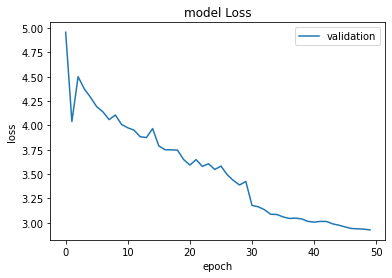

In [18]:
plt.plot(valid_loss)
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='best')
plt.show()

## Evaluation on VOC


In [8]:
'''import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"'''
import numpy as np
VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')

def voc_ap(rec,prec,use_07_metric=False):
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0.,1.1,0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec>=t])
            ap = ap + p/11.

    else:
        # correct ap caculation
        mrec = np.concatenate(([0.],rec,[1.]))
        mpre = np.concatenate(([0.],prec,[0.]))

        for i in range(mpre.size -1, 0, -1):
            mpre[i-1] = np.maximum(mpre[i-1],mpre[i])

        i = np.where(mrec[1:] != mrec[:-1])[0]

        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

def voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES,threshold=0.5,use_07_metric=False,):
    '''
    preds {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target {(image_id,class):[[],]}
    '''
    aps = []
    for i,class_ in enumerate(VOC_CLASSES):
        pred = preds[class_] #[[image_id,confidence,x1,y1,x2,y2],...]
        if len(pred) == 0: #如果这个类别一个都没有检测到的异常情况
            ap = -1
            print('---class {} ap {}---'.format(class_,ap))
            aps += [ap]
            break
        #print(pred)
        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])
        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        npos = 0.
        for (key1,key2) in target:
            if key2 == class_:
                npos += len(target[(key1,key2)]) #统计这个类别的正样本，在这里统计才不会遗漏
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d,image_id in enumerate(image_ids):
            bb = BB[d] #预测框
            if (image_id,class_) in target:
                BBGT = target[(image_id,class_)] #[[],]
                for bbgt in BBGT:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    union = (bb[2]-bb[0]+1.)*(bb[3]-bb[1]+1.) + (bbgt[2]-bbgt[0]+1.)*(bbgt[3]-bbgt[1]+1.) - inters
                    if union == 0:
                        print(bb,bbgt)
                    
                    overlaps = inters/union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt) #这个框已经匹配到了，不能再匹配
                        if len(BBGT) == 0:
                            del target[(image_id,class_)] #删除没有box的键值
                        break
                fp[d] = 1-tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp/float(npos)
        prec = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)
        #print(rec,prec)
        ap = voc_ap(rec, prec, use_07_metric)
        print('---class {} ap {}---'.format(class_,ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))